# <a id='toc1_'></a>[Рынок заведений общественного питания Москвы](#toc0_)

## <a id='toc1_1_'></a>[Описание проекта](#toc0_)
Инвесторы из фонда «Shut Up and Take My Money» решили попробовать себя в новой области и открыть заведение общественного питания в Москве. Заказчики ещё не знают, что это будет за место: кафе, ресторан, пиццерия, паб или бар, — и какими будут расположение, меню и цены.
Для начала они просят вас — аналитика — подготовить исследование рынка Москвы, найти интересные особенности и презентовать полученные результаты, которые в будущем помогут в выборе подходящего инвесторам места.

**Описание данных** `moscow_places.csv`:
- `name` — название заведения;
- `address` — адрес заведения;
- `category` — категория заведения, например «кафе», «пиццерия» или «кофейня»;
- `hours` — информация о днях и часах работы;
- `lat` — широта географической точки, в которой находится заведение;
- `lng` — долгота географической точки, в которой находится заведение;
- `rating` — рейтинг заведения по оценкам пользователей в Яндекс Картах (высшая оценка — 5.0);
- `price` — категория цен в заведении, например «средние», «ниже среднего», «выше среднего» и так далее;
- `avg_bill` — строка, которая хранит среднюю стоимость заказа в виде диапазона, например:
    - «Средний счёт: 1000–1500 ₽»;
    - «Цена чашки капучино: 130–220 ₽»;
    - «Цена бокала пива: 400–600 ₽».

- `middle_avg_bill` — число с оценкой среднего чека, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Средний счёт»:
    - Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
    - Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
    - Если значения нет или оно не начинается с подстроки «Средний счёт», то в столбец ничего не войдёт.
- `middle_coffee_cup` — число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино»:
    - Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
    - Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
    - Если значения нет или оно не начинается с подстроки «Цена одной чашки капучино», то в столбец ничего не войдёт.
- `chain` — число, выраженное 0 или 1, которое показывает, является ли заведение сетевым (для маленьких сетей могут встречаться ошибки):
    - 0 — заведение не является сетевым
    - 1 — заведение является сетевым
- `district` — административный район, в котором находится заведение, например Центральный административный округ;
- `seats` — количество посадочных мест.

## <a id='toc1_2_'></a>[Импорт библиотек](#toc0_)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import re
import json
from folium import Map, Marker, Figure
from folium.plugins import MarkerCluster
import plotly.graph_objects as go
from collections import Counter
from plotly.subplots import make_subplots
import warnings
    
warnings.simplefilter('ignore')


In [2]:
# принимает:
# 'dfs' - список с таблицами
# 'captions' - подписи к таблицам
# 'space_width' - отступы между таблицами

# возвращает:
# выводит в консоль таблицы рядом с друг другом

def display_side_by_side(dfs: list, captions: list, space_width=10):
    output = ""
    combined = dict(zip(captions, dfs))

    for caption, df in combined.items():
        output += (df.style.set_properties(**{'text-align': 'left'})
                   .set_table_attributes("style='display:inline'")
                   .set_caption(caption)._repr_html_())
        output += "\xa0" * space_width

    display(HTML(output))


In [3]:
def choropleth_mapbox_creator(df,color,locations,
                              geojson,
                              featureidkey='properties.name',
                              center={"lat": 55.751244, "lon": 37.618423},
                              zoom=8.7, opacity=.7,height=500,
                              hover_name=None):

    fig = px.choropleth_mapbox(df,
                               geojson=geojson,
                               color=color,
                               locations=locations,
                               featureidkey=featureidkey,
                               center=center,
                               zoom=zoom, opacity=opacity,
                               hover_name=hover_name
                               )
    fig.update_geos(fitbounds="locations")
    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        height=height,
        mapbox_style="carto-positron"
    )
    return fig


In [4]:
def scatter_mapbox_creator(df, lat, lon, color=None, height=500, zoom=10, hover_data=None, hover_name=None):
    fig = px.scatter_mapbox(df, lat="lat", lon="lng", color='name', zoom=zoom, hover_name=hover_name, hover_data=hover_data)
    fig.update_geos(fitbounds="locations")
    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        height=height,
        mapbox_style="carto-positron"
    )
    return fig


In [5]:
def subplots_bar_creator(fig, x_list, y_list, text_list, color_list=None, rows=1, cols=1, for_export=False):    
    for i in range(1, cols+1):
        for j in range(1, rows+1):
            print(i,j)
            fig.append_trace(go.Bar(
                x=x_list[i*j-1],
                y=y_list[i*j-1],
                text=text_list[i*j-1],
                marker_color=color_list[i*j-1]
            ),
                row=j, col=i
            )

    if for_export == True:
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        })

    return fig

In [6]:
# принимает:
# 'phrase' - строку

# возвращает:
# аббревиатуру строки (только первые буквы слов капсом)
def make_acronym(phrase):
    phrase = phrase.replace('-', ' ').split()
    acronym = ""
    for word in phrase:
        acronym = acronym + word[0].upper()
    return acronym


In [7]:
def one_plot_creator(df, x, y, color, text=None,
                     title='default tittle', xaxis_title='default xaxis tittle', yaxis_title='default yaxis tittle',
                     legend_title='default legend tittle', barmode='stack',
                     orientation='v', height=500, showlegend=True, for_export=False):

    fig = px.bar(df, x=x, y=y, color=color, text=text, barmode=barmode)

    fig.update_layout(
        height=height,
        showlegend=showlegend,
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        legend_title=legend_title
    )
    
    if for_export == True:
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        })

    return fig


## <a id='toc1_3_'></a>[Загрузка данных и первичный осмотр](#toc0_)


In [8]:
with open('datasets/admin_level_geomap.geojson', 'r') as f:
    geo_json = json.load(f)


In [9]:
df = pd.read_csv('datasets/moscow_places.csv')
df.sample(5)


,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
8357,Чайхана у Али,кафе,"Москва, Волжский бульвар, 1, корп. 1",Юго-Восточный административный округ,"ежедневно, 10:00–21:00",55.719505,37.743565,4.2,средние,Средний счёт:250–450 ₽,350.0,NaN,0,NaN
1660,Рубим Бургер,кафе,"Москва, улица Нижняя Масловка, 5",Северный административный округ,"ежедневно, 10:00–22:00",55.791746,37.583599,4.5,средние,NaN,NaN,NaN,1,75.0
1637,Кафе Сайгон,кафе,"Москва, улица Сущёвский Вал, 5, стр. 22",Северо-Восточный административный округ,"ежедневно, 11:30–00:00",55.793128,37.592724,4.6,средние,Средний счёт:700–1000 ₽,850.0,NaN,0,80.0
5420,Пончики! Выпекаем на месте,булочная,"Москва, Новокосинская улица, 35",Восточный административный округ,"ежедневно, 08:00–22:00",55.743570,37.866127,4.3,NaN,Средний счёт:от 50 ₽,50.0,NaN,1,4.0
3480,Hite,"бар,паб","Москва, улица 1905 года, 2, стр. 1",Центральный административный округ,"ежедневно, 12:00–00:00",55.755060,37.560185,4.7,NaN,NaN,NaN,NaN,1,NaN


In [10]:
display(df.info())
print('Percent Nan count:')
display(pd.DataFrame(round(df.isna().mean().sort_values()*100,)
                     ).style.background_gradient('YlGnBu'))
print('Duplicates checking, for columns `name` & `address`:')
display(df[df.duplicated(subset=['name', 'address'])].size)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


None

Percent Nan count:


,0
name,0.000000
category,0.000000
address,0.000000
district,0.000000
lat,0.000000
lng,0.000000
rating,0.000000
chain,0.000000
hours,6.000000
seats,43.000000


Duplicates checking, for columns `name` & `address`:


0

### <a id='toc1_3_1_'></a>[Вывод](#toc0_)
- всего в данных храниться информация о 8406 заведениях
- типы данных у всех столбцов верные (кроме `seats` нужно перевести в int)
- пропуски присутствуют в 6 столбцах
- больше всего пропусков в `seats`, `avg_bill`, `price`, `middle_avg_bill`, `middle_coffee_cup`
- нужно как-то обработать столбцы `hours` и `avg_bill` чтобы достать от туда нужную информацию

## <a id='toc1_4_'></a>[Предобработка и подготовка данных](#toc0_)
Для начала переведем все строковые данные в нижний регистр, для удобства и универсальности

In [11]:
for col in ['name', 'category', 'address', 'hours', 'price', 'avg_bill']:
    df[col] = df[col].str.lower()


### <a id='toc1_4_1_'></a>[Дубликаты](#toc0_)
Первым делом посмотрим если в данных дубликаты

In [12]:
print(f'Count full duplicates: {df.duplicated().sum()}')
print(
    f"Duplicates checking, for columns `name` & `address`: {df[df.duplicated(subset = ['name', 'address'])].size}")


Count full duplicates: 0
Duplicates checking, for columns `name` & `address`: 56


Дубликатов нет, как полных так и по заведениям и адресам.

### <a id='toc1_4_2_'></a>[Пропуски](#toc0_)
Посмотрим какие пропуски можно заполнить

In [13]:
display(pd.DataFrame(round(df.isna().mean().sort_values()*100,)
                     ).style.background_gradient('YlGnBu'))


,0
name,0.000000
category,0.000000
address,0.000000
district,0.000000
lat,0.000000
lng,0.000000
rating,0.000000
chain,0.000000
hours,6.000000
seats,43.000000


In [14]:
print('Count rows with all problem data columns (without `hours`):', end=' ')
print(len(df.query('seats != seats & avg_bill!=avg_bill & price!=price & middle_avg_bill!=middle_avg_bill & middle_coffee_cup!=middle_coffee_cup')))

print('Count rows with ALL problem data columns:', end=' ')
print(len(df.query('seats != seats & avg_bill!=avg_bill & price!=price & middle_avg_bill!=middle_avg_bill & middle_coffee_cup!=middle_coffee_cup & hours!=hours')))


Count rows with all problem data columns (without `hours`): 2072
Count rows with ALL problem data columns: 235


Пропуски есть и в некоторых столбцах их очень много, но на данный момент заменить их не получится. Возможно в ходе исследования, станет понятнее и тогда можно вернуться к этому пункту.

Так же есть строки с пропусками во всех "проблемных" столбцах 2072 строки (исключая `hours`) и 235 строк (включая `hours`). 235 строк это не много можно бы было их удалить но в них содержится информация о место положении и типе заведения, считаю что удалять их не нужно.

### <a id='toc1_4_3_'></a>[Проверка на ошибки в данных](#toc0_)

,0
0,Северный административный округ
1,Северо-Восточный административный округ
2,Северо-Западный административный округ
3,Западный административный округ
4,Центральный административный округ
5,Восточный административный округ
6,Юго-Восточный административный округ
7,Южный административный округ
8,Юго-Западный административный округ
,0


Watch for scatter for coordinates:


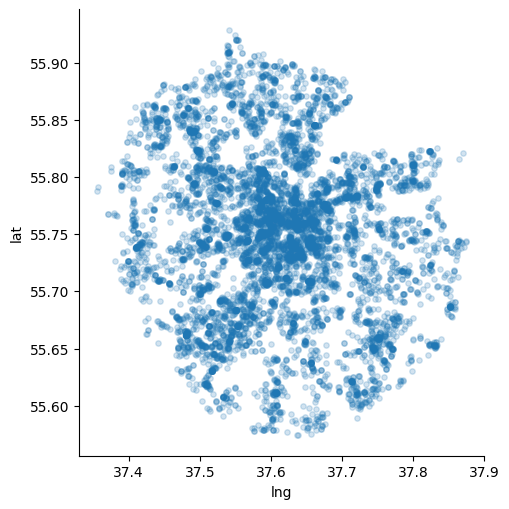

In [15]:
display_side_by_side([
    pd.DataFrame(df['district'].unique()),
    pd.DataFrame(df['category'].unique()),
    pd.DataFrame(df['rating'].describe())
],
    [
    'Unique values of `district`',
    'Unique values of `category`',
    'Describe of `rating`'
], 10)
print('Watch for scatter for coordinates:')
sns.lmplot(x="lng", y="lat", data=df, fit_reg=False,
           scatter_kws={'s': 15, 'alpha': 0.2})


На первый взгляд, ошибок в основных столбцах нет:
- "неверных" округов нет
- категории логично разбиты
- рейтинг не имеет аномальных значений
- координаты образуют собой карту Москвы

### <a id='toc1_4_4_'></a>[Добавление новых столбцов](#toc0_)

- добавим новый столбец `street` с названиями улиц из столбца с адресом.
- добавим новый столбец `is_24/7` с обозначением, что заведение работает ежедневно и круглосуточно (24/7)
- добавим столбец `district_short` с аббревиатурой района

In [16]:
df['district_short'] = df['district'].apply(make_acronym)

In [17]:
def get_street(address):
    address = address.strip().lower()
    address = re.sub(r'\s*,\s*', ',', address)
    address = re.split(',|\.', address)
    return address[1]


In [18]:
def is_24_7(time):
    if time != time:
        return np.nan
    elif time == 'ежедневно, круглосуточно':
        return True
    else:
        return False


In [19]:
df['street'] = df['address'].apply(get_street)
df['is_24_7'] = df['hours'].apply(is_24_7)

df.sample(3)


,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,district_short,street,is_24_7
3832,онегин,"бар,паб","москва, страстной бульвар, 4, стр. 3",Центральный административный округ,"пн-чт 11:00–00:00; пт 11:00–03:00; сб,вс 12:00...",55.765321,37.608243,4.4,средние,цена бокала пива:190–500 ₽,NaN,NaN,0,90.0,ЦАО,страстной бульвар,False
5395,чаме-чаме,ресторан,"москва, рязанский проспект, 2/1к2б",Юго-Восточный административный округ,"ежедневно, 11:00–23:00",55.728962,37.739746,4.3,средние,средний счёт:600–1000 ₽,800.0,NaN,1,NaN,ЮВАО,рязанский проспект,False
6363,татбургер,кофейня,"москва, южнопортовая улица, 18",Юго-Восточный административный округ,"ежедневно, 10:00–22:00",55.706703,37.684522,4.4,средние,средний счёт:600–800 ₽,700.0,NaN,0,30.0,ЮВАО,южнопортовая улица,False


### <a id='toc1_4_5_'></a>[Вывод](#toc0_)
- все строковые данные были переведены в нижний регистр
- дубликатов найдено не было
- восстановить пропуски на данный момент нет возможности, как и причины, возможно стоит вернутся к этому вопросу позже
- ошибок в данных найдено не было
- были добавлены столбцы с **названиями улиц** и с **маркером работы 24/7**

## <a id='toc1_5_'></a>[Анализ данных](#toc0_)

### <a id='toc1_5_1_'></a>[Анализ категорий заведений](#toc0_)
Про анализируем категории заведений представленные в данных. Исследуем количество объектов общественного питания по категориям.

In [20]:
category = pd.DataFrame(df.groupby('category')['category'].count())
fig = px.pie(category, values='category', names=category.index)
fig.update_layout(
    height=450,
    showlegend=True,
    title='Ratio cafes by category',
    legend_title='Category'
)
fig.show()


#### <a id='toc1_5_1_1_'></a>[Вывод](#toc0_)
Список заведений по категориям (по убыванию количества):
- 28% - `кафе`
- 24% - `ресторан`
- 17% - `кофейня`
- 7%-9% - `бар/паб`, `пиццерия`, `быстрое питание`
- 3%-4% - `столовая`, `булочная` 

Ожидаемо больше всего заведений в категориях `кафе`, `ресторан` и `кофейня`. Остальные типа, сильно уступают первой тройке.

### <a id='toc1_5_2_'></a>[Анализ количества посадочных мест](#toc0_)
Проанализируем количество посадочных мест в местах по категориям.

In [21]:
def categorization_seats(seats):
    if (seats != seats):
        return np.nan
    seats = int(seats)
    if (seats == 0):
        return '0'
    elif (seats <= 20):
        return '1 - 20'
    elif (seats <= 80):
        return '21 - 80'
    elif (seats <= 120):
        return '81 - 120'
    else:
        return '121 +'


Разобьем все кафе по категориям по количеству посадочных мест, категории выделим на основе информации о всех кафе.

In [22]:
df.groupby(by='category', as_index=False).agg(
    min=('seats', 'min'),
    max=('seats', 'max'),
    mean=('seats', 'mean'),
    median=('seats', 'median')
)


,category,min,max,mean,median
0,"бар,паб",0.0,1288.0,124.532051,82.5
1,булочная,0.0,625.0,89.385135,50.0
2,быстрое питание,0.0,1040.0,98.891117,65.0
3,кафе,0.0,1288.0,97.512315,60.0
4,кофейня,0.0,1288.0,111.199734,80.0
5,пиццерия,0.0,1288.0,94.496487,55.0
6,ресторан,0.0,1288.0,121.944094,86.0
7,столовая,0.0,1200.0,99.750000,75.5


Выделим следующие категории:
- `0` - заведения без посадочных мест
- `0-20` - заведения маленького размера
- `20-80` - заведения среднего размера
- `80-120` - заведения большего размера
- `120+` - очень большие заведения

In [23]:
df['seats_category'] = df['seats'].apply(categorization_seats)

In [24]:
fig = one_plot_creator(
    df=df.groupby(['category', 'seats_category'], as_index=False).agg(count=('category', 'count')).sort_values('count', ascending=False),
    x='category', y='count', color='seats_category',
    title='Distribution of type count seats cafes by category',
    xaxis_title='category',
    yaxis_title='count cafe',
    legend_title='Seats category',
    barmode='group',
    height=450
)
fig.show()

#### <a id='toc1_5_2_1_'></a>[Вывод](#toc0_)
На графике хорошо видно:
- что во всех категориях заведений доминирует категория `заведений среднего размера` (от 21 до 80 посадочных мест)
- следом в во всех категория идет `заведение очень большего` размера (от 121 посадочного места)
- потом `заведения большего размера` (от 81 до 120 посадочных мест)
- и далее `заведения маленького размера` (от 1 до 20 посадочных мест)
- ожидаемо меньше всего заведений `без посадочных мест`

### <a id='toc1_5_3_'></a>[Анализ сетевых заведений](#toc0_)

In [25]:
chains = df.groupby(by=['category', 'chain'], as_index=False).agg(
    count=('name', 'count'))
chains.loc[chains['chain'] == 0, 'chain'] = 'is not chain'
chains.loc[chains['chain'] == 1, 'chain'] = 'is chain'
for i in range(len(chains)):
    chains.at[i, 'ratio'] = str(round(
        chains.loc[i]['count']/len(df[df['category'] == chains.loc[i]['category']]), 1) * 100) + '%'


In [26]:
fig = one_plot_creator(
    df=chains,
    x='category', y='count', color='chain', text='ratio',
    title='Ratio & count of chain cafes by category',
    xaxis_title='category', yaxis_title='count cafe',
    legend_title='Is cafes chain',height=450
)
fig.show()


In [27]:
print(
    f"Chain\'s cafe \ncount: {len(df.query('chain == 0'))}\nratio: {round(1 - df['chain'].mean(),2)}\n")
print(
    f"Not chain\'s cafe\ncount: {len(df.query('chain == 1'))}\nratio: {round(df['chain'].mean(),2)}")


Chain's cafe 
count: 5201
ratio: 0.62

Not chain's cafe
count: 3205
ratio: 0.38


#### <a id='toc1_5_3_1_'></a>[Вывод](#toc0_)
Только `40%` всех заведений являются сетевыми. 

Самые большие проценты сетевых заведений в следующих категориях:
- `60%` булочная
- `50%` кофейня и пиццерия
- `40%` ресторан и быстрое питание

### <a id='toc1_5_4_'></a>[Анализ заведений по названию](#toc0_)
Найдем топ-15 популярных сетей в Москве. Найдем признак, который их объединяет и категорию заведений?

In [28]:
top_15_cafes = (
    df.groupby('name', as_index=False).agg(count=('category', 'count'))
    .sort_values('count', ascending=False)
)
print('List before cleaning')
display(top_15_cafes.head(15))

black_list = df['category'].unique().tolist()
black_list.extend(['хинкальная', 'шаурма', 'чайхана'])

print('List after cleaning')
display(top_15_cafes[~top_15_cafes['name'].isin(black_list)].head(15))
top_15 = top_15_cafes[~top_15_cafes['name'].isin(black_list)].head(15)[
    'name'].tolist()

top_15 = df[df['name'].isin(top_15)]



List before cleaning


,name,count
2825,кафе,189
5418,шоколадница,120
2532,домино'с пицца,77
2500,додо пицца,74
1137,one price coffee,72
5491,яндекс лавка,69
413,cofix,65
1263,prime,50
4993,хинкальная,44
5319,шаурма,43


List after cleaning


,name,count
5418,шоколадница,120
2532,домино'с пицца,77
2500,додо пицца,74
1137,one price coffee,72
5491,яндекс лавка,69
413,cofix,65
1263,prime,50
3178,кофепорт,42
3236,кулинарная лавка братьев караваевых,39
4700,теремок,38


После создания сводной таблицы, попали заведения без названия(напрм. "кафе", "ресторан" и тд.), чтобы они не искажали исследование, убрали из сводной таблицы.

In [29]:
fig = scatter_mapbox_creator(df=top_15, lat='lat', lon='lng', color='name', zoom=9, hover_name='name')
fig.show()

In [30]:
fig = one_plot_creator(
    df=top_15.groupby(['name', 'category'], as_index=False).agg(count=('category', 'count')).query('count>8'),
    x='name', y='count', color='category', 
    title='Most popular category by top 15 chains ',
    xaxis_title='chains name', yaxis_title='count cafe',
    legend_title='Category', height=450
)
fig.show()

In [31]:
fig = one_plot_creator(
    df=top_15.groupby(['name'], as_index=False).agg(count=('rating', 'mean')),
    x='name', y='count', color=None, 
    title='Cafes AVG rating by top 15 chains ',
    xaxis_title='chains name', yaxis_title='rating',
    showlegend=False, barmode='group'
)
fig.update_layout(
    yaxis_range=[3.8, 4.5],
    height=450
)
fig.show()

#### <a id='toc1_5_4_1_'></a>[Вывод](#toc0_)
Составив топ 15 самых популярных заведений, получили:
- ожидаемо все заведения являются `сетевыми`
- почти все заведения, либо расположены в центре города, либо равномерно покрывают весь город
- самые популярные категории `кофейня`, `кафе`, `ресторан`, `пиццерия` и `булочная`
- `круглосуточных` заведений из списка очень мало
- средний `рейтинг` у всех заведений находиться в промежутке `от 3.9 до 4.5`
- данных по ценам очень мало, поэтому по ним сказать нечего

### <a id='toc1_5_5_'></a>[Анализ по административным районам](#toc0_)
Проанализируем типы заведений по админ. районам.

In [32]:
district_count = df.groupby(
    ['district', 'category'], as_index=False).agg(count=('name', 'count'))
district_count['district'] = district_count['district'].apply(make_acronym)
district_count['parent'] = district_count['district']
district_count['district'] = district_count['category']
district_count.loc[len(district_count.index)] = [
    "Москва", '', district_count['count'].sum(), '']

for d in district_count['parent'].unique():
    district_count.loc[len(district_count.index)] = [
        d, '', district_count[district_count['parent'] == d]['count'].sum(), 'Москва']


Подготовим сводную таблицу под график `sunburst`

In [33]:
fig = px.sunburst(
    district_count,
    names='district',
    parents='parent',
    values='count',
    branchvalues="total",
    title='Distribution of cafes category by district'
)
fig.update_layout(
    grid=dict(columns=2, rows=1),
    margin=dict(t=50, l=0, r=0, b=0),
    height=450
)
fig.show()


Как вариант сделаем все тоже самое но на гистограмме.

In [34]:
district_count = (
    df.groupby(['district_short', 'category'], as_index=False)
    .agg(count=('name', 'count')).sort_values('count', ascending=False)
)

In [35]:
fig = one_plot_creator(
    df=district_count,
    x='district_short', y='count', color='category', 
    title='Distribution of cafes category by district',
    xaxis_title='district', yaxis_title='cafe count',
    legend_title='Cafe category', barmode='group',height=450
)
fig.show()


#### <a id='toc1_5_5_1_'></a>[Вывод](#toc0_)
Ожидаемо больше всего заведений в `ЦАО` так же в нем в отличие от других районов, доминируют `рестораны`.
В остальных районах количество заведений не сильно разница (от 700 до 900 шт.), выделить можно только `СЗАО` в котором всего 409 заведений


### <a id='toc1_5_6_'></a>[Анализ рейтинга заведений](#toc0_)
Для начала про анализируем средние рейтинги по району

In [36]:
fig = choropleth_mapbox_creator(
    df=df,
    geojson=geo_json,
    color='rating',
    locations='district',
    opacity=.8,height=500,
    hover_name='rating')
fig.show()


Теперь посмотрим на средние рейтинг по категориям в зависимости от района.

In [37]:
rating_dist_cat = (
    df.groupby(['category', 'district_short'], as_index=False)
    .agg(count=('rating', 'mean')).sort_values('count', ascending=False)
)

In [38]:
fig = one_plot_creator(
    df=rating_dist_cat,
    x='district_short', y='count', color='category', 
    title='AVG cafe rating by category',
    xaxis_title='district', yaxis_title='AVG rating',
    legend_title='Cafe category', barmode='group'
)
fig.update_layout(
    yaxis_range=[3.9, 4.5],
    height=450
)
fig.show()

#### <a id='toc1_5_6_1_'></a>[Вывод](#toc0_)
По графикам можно сказать следующее:
- самый высокий рейтинг по всем районам у `баров`
- следом идут и примерно в одном оценочном диапазоне `пиццерия`, `кофейня` и `рестораны` 
- самый низкий рейтинг почти по всем районам у `быстрого питания` и `кафе`
- самый "залайканый" район `ЦАО`
- район с самыми низкими оценками `ЮВАО`

### <a id='toc1_5_7_'></a>[Карта заведений](#toc0_)

In [39]:
fig = px.scatter_mapbox(df, lat="lat", lon="lng", color='category',
                        zoom=9, hover_name="name", hover_data=["category", "rating"])
fig.update_geos(fitbounds="locations")
fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox_style="carto-positron",
    height=500,
)
fig.show()

### <a id='toc1_5_8_'></a>[Топ-15 улиц по количеству заведений](#toc0_)

In [40]:
streets = df.groupby('street').agg(count=('name', 'count')).sort_values(
    'count', ascending=False).head(15).index.tolist()
street_cat = df[df['street'].isin(streets)].groupby(['street', 'category'], as_index=False).agg(
    count=('name', 'count')).sort_values('count', ascending=False)


In [41]:
fig = one_plot_creator(
    df=street_cat,
    x='count', y='street', color='category', text='count',
    title='Cafe category count by street',
    xaxis_title='count cafe', yaxis_title='street',
    legend_title='Cafe category',
    orientation='h'
)
fig.show()


#### <a id='toc1_5_8_1_'></a>[Вывод](#toc0_)
По графику видно:
- больше всего заведений на `пр. Мира`, `ул. Профсоюзной`. `пр. Вернадского` и `Ленинский пр.` (обусловлено это тем что эти улицы очень длинные)
- самые популярные категории заведений `кафе` и `ресторан`
- далее идут `кофейни`, `быстрое питание` и `пиццерии`

### <a id='toc1_5_9_'></a>[Улицы с 1 заведением](#toc0_)

In [42]:
single_cafe = df.groupby('street').agg(count=('name', 'count')).sort_values(
    'count', ascending=False).query('count == 1').index.tolist()
single_cafe_street = df[df['street'].isin(single_cafe)].groupby(
    'category', as_index=False).agg(count=('name', 'count')).sort_values('count', ascending=False)


In [43]:
fig = one_plot_creator(
    df=single_cafe_street,
    x='count', y='category', color='category', text='count',
    title='Solo cafe category count by street',
    xaxis_title='count cafe', yaxis_title='category',
    showlegend=False,
    orientation='h',
    height=450
)
fig.show()

#### <a id='toc1_5_9_1_'></a>[Вывод](#toc0_)
По графику видно:
- на не популярных улицах больше всего `кафе`
- далее идут `рестораны` и `кофейни`
- всех остальных категорий очень мало

Можно предположить что связано это с тем, что такие заведения как `столовая`, `бар`, `пиццерия` и `быстрое питание`, открывают там где большой поток клиентов. А `кафе`, `ресторан` и `кофейни`, могут открывать в местах где нет конкурентов и без огромной проходимости.

### <a id='toc1_5_10_'></a>[Анализ ценового диапазона](#toc0_)

In [44]:
dist_avg_bill = df.groupby('district', as_index=False).agg(
    avg_bill=('middle_avg_bill', 'mean'))
dist_avg_bill['avg_bill'] = round(dist_avg_bill['avg_bill'], 2)

In [45]:
fig = choropleth_mapbox_creator(
    df=dist_avg_bill,
    geojson=geo_json,
    color='avg_bill',
    locations='district',
    opacity=.8,height=500,
    hover_name='avg_bill')
fig.show()

#### <a id='toc1_5_10_1_'></a>[Вывод](#toc0_)
- ожидаемо самый дорогой средний чек в `ЦАО` и `ЗАО` (самые дорогие районы Москвы)
- самые дешевый средний чек в `СВАО` и `ЮВАО`
- остальные районы не сильно отличаются друг от друга

В целом отдаление от центра дальше чем за `ЦАО` не сильно влияет на средний чек, дальше работает правильно "дорогой район - дороже, дешевый - дешевле"

### <a id='toc1_5_11_'></a>[Анализ круглосуточных заведений](#toc0_)

In [46]:
fig = choropleth_mapbox_creator(
    df=df.query('is_24_7==True').groupby('district', as_index=False).agg(is_24_7=('is_24_7', 'count')),
    geojson=geo_json,
    color='is_24_7',
    locations='district',
    opacity=.8,height=500,
    hover_name='is_24_7')
fig.show()


In [47]:
fig = one_plot_creator(
    df=df.query('is_24_7==True').groupby('category', as_index=False).agg(is_24_7=('is_24_7', 'count')).sort_values('is_24_7', ascending=False),
    x='is_24_7', y='category', color='category', text='is_24_7',
    title='Count 24/7 cafes by category',
    xaxis_title='count cafe', yaxis_title='category',
    showlegend=False,
    orientation='h',
    height=450
)

fig.show()

#### <a id='toc1_5_11_1_'></a>[Вывод](#toc0_)
Чаще всего круглосутоными заведениями являются `Кафе`. `быстрое питание` и `рестораны`, остальных категорий заведений сильно меньше, ожидаемо количество круглосуточных `столова` и `булочная` меньше всех.

Так же ожидаемо что больше всего круглосуточных заведений в `ЦАО` в остальных районах показатель примерно одинаковый. Кроме `СЗАО` он очень сильно отстает от остальных.

### <a id='toc1_5_12_'></a>[Анализ заведений с низкими и высокими рейтингами](#toc0_)
На основе всего датафрейма найдем "черту" низкого и высокого рейтинга.

In [48]:
df['rating'].describe()


count    8406.000000
mean        4.229895
std         0.470348
min         1.000000
25%         4.100000
50%         4.300000
75%         4.400000
max         5.000000
Name: rating, dtype: float64

- за низкий рейтинг примем заведения с рейтингом ниже 4.1 (таких заведений примерно 25%)
- за высокий рейтинг примем заведения с рейтингом выше 4.4 (таких заведений тоже примерно 25%)

In [49]:
def ratio_rating(row):
    category = row['category']
    len_by_rat = row['count']
    len_all = df.query('category == @category ')['name'].size
    return round(len_by_rat/len_all * 100, 2)


Функция для подсчета относительного количества "плохих и хороших" заведений по категориям.

In [50]:
low_rating = (
    df.query('rating < 4.1')
    .groupby('category', as_index=False)
    .agg(avg_bill=('middle_avg_bill', 'mean'), count=('lat', 'count'))
    .sort_values('count', ascending=False)
)

low_rating['avg_bill'] = round(low_rating['avg_bill'], 1)
low_rating['count_ratio'] = low_rating.apply(ratio_rating, axis=1)


hight_rating = (
    df.query('rating > 4.4')
    .groupby('category', as_index=False)
    .agg(avg_bill=('middle_avg_bill', 'mean'), count=('name', 'count'))
    .sort_values('count', ascending=False)
)

hight_rating['avg_bill'] = round(hight_rating['avg_bill'], 1)
hight_rating['count_ratio'] = hight_rating.apply(ratio_rating, axis=1)


In [51]:
fig = go.Figure()

fig.add_trace(go.Bar(x=low_rating['category'], y=low_rating['count'], text=low_rating['count'],
                     name='count low rating', marker_color='rgb(238, 85, 59)'))


fig.add_trace(go.Bar(x=low_rating['category'], y=low_rating['count_ratio']*10, text=low_rating['count_ratio'],
                     name='ratio low rating', marker_color='rgb(170, 74, 54)', marker_pattern_shape='x'))

fig.add_trace(go.Bar(x=hight_rating['category'], y=hight_rating['count'], text=hight_rating['count'],
                     name='count hight rating', marker_color='rgb(99, 110, 250)'))

fig.add_trace(go.Bar(x=hight_rating['category'], y=hight_rating['count_ratio']*10, text=hight_rating['count_ratio'],
                     name='ratio hight rating', marker_color='rgb(61, 67, 149)', marker_pattern_shape='x'))

fig.update_traces(marker_pattern_fgcolor='black')
fig.update_layout(
    height=450,
    showlegend=True,
    title='Count & ratio low and hight rating cafes by category',
    xaxis_title='category',
    yaxis_title='count cafes',
    legend_title='Count & ratio cafe rating'
)
fig.show()


In [52]:
fig = go.Figure()

fig.add_trace(go.Bar(x=low_rating['category'], y=low_rating['avg_bill'], text=low_rating['avg_bill'],
                     name='low rating', marker_color='rgb(238, 85, 59)'))

fig.add_trace(go.Bar(x=hight_rating['category'], y=hight_rating['avg_bill'], text=hight_rating['avg_bill'],
                     name='hight rating', marker_color='rgb(99, 110, 250)'))

fig.update_layout(
    height=450,
    showlegend=True,
    title='Avg bill low and hight rating cafes by category',
    xaxis_title='category',
    yaxis_title='avg bill',
    legend_title='AVG cafe rating'
)
fig.show()


#### <a id='toc1_5_12_1_'></a>[Вывод](#toc0_)
- хороших `кафе` и `быстрого питания` меньше как количественно так и относительно
- `ресторанов`, `кофейнь`, `пиццерий`  и `баров` больше
- в относительных количествах хороших `баров` и плохих ресторанов `быстрого питания` сильно больше чем в других категориях

По среднему чеку можно выделить следующее:
- если заведение не `столова` и не ресторан `быстрого питания` то иметь хорошие отзывы прибыльно (или затратно))
- самая большая разница в среднем чеке между хорошими и плохими заведениями у `ресторанов`, `баров` и `пиццерий`

### <a id='toc1_5_13_'></a>[Вывод](#toc0_)

Все очень сильно меняется от района к району, но в целом подытожить можно так:
- больше всего заведений в категориях `кафе`, `ресторан` и `кофейня`
- чаще всего `заведения среднего размера` (от 21 до 80 посадочных мест)
- Только `40%` всех заведений являются сетевыми ( у булочных `60%`  и кофейня, пиццерия `50%`)
- самые популярные заведения сетевые, категории в них :`кофейня`, `кафе`, `ресторан`, `пиццерия` и `булочная`.
- больше всего заведений в `ЦАО`, так же в нем в отличие от других районов, доминируют `рестораны`
- самый высокий рейтинг по всем районам у `баров`, самый низкий рейтинг почти по всем районам у `быстрого питания` и `кафе`.
- самый "залайканый" район `ЦАО` , район с самыми низкими оценками `ЮВАО`.
- больше всего заведений на `пр. Мира`, `ул. Профсоюзной`. `пр. Вернадского` и `Ленинский пр.` (обусловлено это тем что эти улицы очень длинные)
- на не популярных улицах больше всего `кафе`, `рестораны` и `кофейни`
- самый дорогой средний чек в `ЦАО` и `ЗАО` (самые дорогие районы Москвы), а самый дешевый средний чек в `СВАО` и `ЮВАО`.
- чаще всего круглосутоными заведениями являются `кафе`, `быстрое питание` и `рестораны`, количество круглосуточных `столова` и `булочная` меньше всех
- хороших `кафе` и `быстрого питания` меньше как количественно так и относительно, а `ресторанов`, `кофейнь`, `пиццерий`  и `баров` больше
- если заведение не `столова` и не ресторан `быстрого питания` то иметь хорошие отзывы прибыльно

## <a id='toc1_6_'></a>[Детализация исследования: "открытие кофейни"](#toc0_)
В этом разделе я решил отойти от плана из задания и сделать по своему.

Первым делом добавим следующие данне данные:
- количестве проживающих людей по каждому району
- площадь райна (в кв. км)
- усредненую цену на коммерческую недвижимость (за кв. м)
- количество новостороек по районам

In [53]:
msc_population = pd.read_csv('datasets/msc_data.csv')
msc_population['density'] = round(
    msc_population['population']/msc_population['square'], 3)
msc_population['cafe_per_person'] = round(
    msc_population['cafe_count']/msc_population['population']*1000_000, 2)
msc_population['district_short'] = msc_population['district'].apply(
    make_acronym)

cafe = df.query('category == "кофейня"')
cafe['district_short'] = cafe['district'].apply(make_acronym)


In [54]:
msc_population

,district,square,population,cafe_count,building_new,rent_cost,density,cafe_per_person,district_short
0,Восточный административный округ,154.84,1524265,105,659,2659,9844.129,68.89,ВАО
1,Западный административный округ,153.03,1395986,150,2270,2802,9122.303,107.45,ЗАО
2,Северный административный округ,113.73,1186128,193,504,2311,10429.333,162.71,САО
3,Северо-Восточный административный округ,101.88,1432571,159,910,2121,14061.356,110.99,СВАО
4,Северо-Западный административный округ,93.28,1011387,62,1560,2802,10842.485,61.30,СЗАО
5,Центральный административный округ,66.18,779352,428,732,3323,11776.247,549.17,ЦАО
6,Юго-Восточный административный округ,117.56,1431746,89,2311,3050,12178.853,62.16,ЮВАО
7,Юго-Западный административный округ,111.36,1446432,96,1708,2308,12988.793,66.37,ЮЗАО
8,Южный административный округ,131.77,1791187,131,732,2075,13593.284,73.14,ЮАО


Сразу добавим в таблицу `msc_population` столбцы:
- с аббревиатурой района
- население района
- площадь района
- количество кофеен в районе
- плотностью населения по районам (кол-во проживающих / площадь района)
- количество кафе на 1 млн. проживающих в районе
- цену за 1 кв. м коммерческой недвижимости

А так же сделаем срез из общей таблицы, выбрав только `кофейни`

### <a id='toc1_6_1_'></a>[Расположение](#toc0_)
Смотреть на количество `кофейнь` по районам большого смысла не имеет, так как все районы разной площади, с разным количеством населения и тд. Поэтому лучше посчитать `индекс количества кафе на человека` по району и отобразить это на карте.

P.S. предварительно убрав `ЦАО` так как он будет сильно перетягивать на себя вес.

In [55]:
fig = choropleth_mapbox_creator(
    df=msc_population.sort_values('cafe_per_person').head(-1),
    geojson=geo_json,
    color='cafe_per_person',
    locations='district',
    opacity=.8,height=500,
    hover_name='cafe_per_person')
fig.show()


#### <a id='toc1_6_1_1_'></a>[Вывод](#toc0_)
На карте хорошо видно что:
- `СЗАО`, `ЮВАО` и `ЮЗАО` самые перспективные районы для открытия `кофейни`, так как там значение индекс наименьшее
- в остальных районах индексы `в 2-3 раза выше`, что значит что в них конкуренция будет больше
- очевидно что в `ЦАО` значение индекса зашкаливает, хоть в этом районе и самая большая проходимость, там так же и самая большая конкуренция


### <a id='toc1_6_2_'></a>[Часы работы](#toc0_)
Проанализируем сколько и где `круглосуточных кофейнь`

In [56]:
is_24_7 = cafe.groupby(by=['district_short', 'is_24_7'], as_index=False).agg(count=('name', 'count'))

In [57]:
fig = one_plot_creator(
    df=is_24_7.sort_values('count', ascending=False),
    x='district_short', y='count', color='is_24_7', text='count',
    title='Count cafes 24/7 by district',
    xaxis_title='district', yaxis_title='count cafes',
    legend_title='Is cafes work 24/7', height=450
)

fig.show()


#### <a id='toc1_6_2_1_'></a>[Вывод](#toc0_)
`Круглосуточных кофейнь` ожидаемо слишком мало для проведения объективного исследования. Но возможно это могло бы стать "фишкой" для нового заведения.

### <a id='toc1_6_3_'></a>[Рейтиги и цены](#toc0_)
Построим графики:
- по среднему `рейтингу кофейнь` по районам
- по средней `цене чашки кофе` по районам

In [58]:
cafe_rating_cost = cafe.groupby(by='district_short', as_index=False).agg(
    count=('rating', 'mean'), avg_cup=('middle_coffee_cup', 'mean'))
cafe_rating_cost['count'] = round(cafe_rating_cost['count'], 2)
cafe_rating_cost['avg_cup'] = round(cafe_rating_cost['avg_cup'])


In [59]:
colors_1 = ['rgb(238, 85, 59)',] * 9
colors_1[3] = 'rgb(0, 204, 151)'

color_2 = ['rgb(97, 70, 255)',] * 9
color_2[2] = 'rgb(0, 204, 151)'

fig = make_subplots(rows=1, cols=2,
                    x_title='district',
                    subplot_titles=('AVG cafe rating by district',
                                    'AVG cup of coffee cost by district'))

cafe_rating_cost = cafe_rating_cost.sort_values('count', ascending=False)
fig.append_trace(go.Bar(x=cafe_rating_cost['district_short'], y=cafe_rating_cost['count'], text=cafe_rating_cost['count'],
                        marker_color=colors_1), row=1, col=1)

cafe_rating_cost = cafe_rating_cost.sort_values('avg_cup', ascending=False)
fig.add_trace(go.Bar(x=cafe_rating_cost['district_short'], y=cafe_rating_cost['avg_cup'], text=cafe_rating_cost['avg_cup'],
                     name='count low rating', marker_color=color_2), row=1, col=2)

fig['layout']['yaxis']['title'] = 'AVG rating'
fig['layout']['yaxis2']['title'] = 'AVG coffee cup cost'

fig.update_layout(
    height=450,
    showlegend=False,
    yaxis2=dict(range=[140, 195]),
    yaxis1=dict(range=[4, 4.4]))

fig.show()


#### <a id='toc1_6_3_1_'></a>[Вывод](#toc0_)
Смотреть на рейтинги есть смысл только в плоскости `"там где рейтинг ниже нехватает хороших кофейнь"`, на графике видно что различия в рейтинге очень малы.

По `цене за чашку кофе`:
- неожиданно самую дорогую чашку кофе можно выпить в `ЗАО`
- следом идет `ЦАО`
- а на 3 месте по стоимости `ЮЗАО`
  
  
Именно в `ЮЗАО` индекс кол-во кофейнь на человека один из самых низких.

Нужно посмотреть на этот район внимательнее.

### <a id='toc1_6_4_'></a>[Доп. исследования](#toc0_)
В конце посмотрим на районы, и выберем подходящий, так же ответить на вопрос где территориально открытие кофейни было бы более оправдано.

Для начала построим графики (эти графики дублируют информацию выше но так лучше видно ход мыслей):
- количество `кофейнь` по районам 
- индекс количества `кофейнь` на человека по райнам

In [60]:
msc_population['cafe_per_person'] = round(msc_population['cafe_per_person'], 6)

colors_1 = ['rgb(238, 85, 59)',] * 9
colors_1[6] = 'rgb(0, 204, 151)'

colors_2 = ['rgb(99, 110, 250)',] * 9
colors_2[6] = 'rgb(0, 204, 151)'

fig = make_subplots(rows=1, cols=2,
                    x_title='district',
                    subplot_titles=('Count coffee shop by district',
                                    'Count coffee shop per person by district'))

msc_population = msc_population.sort_values('cafe_count', ascending=False)
fig.append_trace(go.Bar(x=msc_population['district_short'], y=msc_population['cafe_count'], text=msc_population['cafe_count'],
                        marker_color=colors_1), row=1, col=1)

msc_population = msc_population.sort_values('cafe_per_person', ascending=False)
fig.append_trace(go.Bar(x=msc_population['district_short'], y=msc_population['cafe_per_person'], text=msc_population['cafe_per_person'],
                        marker_color=colors_2), row=1, col=2)

fig['layout']['yaxis']['title'] = 'count coffee shop'
fig['layout']['yaxis2']['title'] = 'coffee shop per person'

fig.update_layout(
    height=450,
    showlegend=False,
    yaxis1=dict(range=[30, 440]))


fig.show()


Намерено выделяем `ЮЗАО`, та как он на данный момент самый перспективный.

Далее посмотрим:
- на `цены аренды коммерческой недвижимости`
- количество `строящихся зданий` по районам

In [61]:
colors_1 = ['rgb(255, 31, 115)',] * 9
colors_1[6] = 'rgb(0, 204, 151)'

colors_2 = ['rgb(97, 70, 255)',] * 9
colors_2[2] = 'rgb(0, 204, 151)'

fig = make_subplots(rows=1, cols=2,
                    x_title='district',
                    subplot_titles=('Commercial rent per metre cost by district',
                                    'Buildings under construction'))


msc_population = msc_population.sort_values('rent_cost', ascending=False)
fig.append_trace(go.Bar(x=msc_population['district_short'], y=msc_population['rent_cost'], text=msc_population['rent_cost'],
                        marker_color=colors_1), row=1, col=1)

msc_population = msc_population.sort_values('building_new', ascending=False)
fig.append_trace(go.Bar(x=msc_population['district_short'], y=msc_population['building_new'], text=msc_population['building_new'],
                        marker_color=colors_2), row=1, col=2)

fig['layout']['yaxis']['title'] = 'cost per metre'
fig['layout']['yaxis2']['title'] = 'new buildings count'

fig.update_layout(
    height=450,
    showlegend=False,
    yaxis1=dict(range=[1500, 3500]))

fig.show()


`ЮЗАО` снова становиться фаворитом:
- один из `самых дешевых` районов по `средней цене за кв. м` (7 из 9)
- `на 3 месте` по количеству `строящихся зданий`, это значит что в ближайшей проспектике увеличение количества клиентов



И в конце посмотрим на `ЮЗАО` повнимательнее, расставив маркеры с конкурентами:
- `цвета` говорят о `рейтинге`
- `размер` говорить о `цене за чашку кофе`

In [62]:
only_UZAO = cafe.query('district_short == "ЮЗАО"')
only_UZAO['middle_coffee_cup'] = round(
    only_UZAO['middle_coffee_cup'].fillna(only_UZAO['middle_coffee_cup'].mean()))


In [63]:
fig = px.scatter_mapbox(only_UZAO, lat="lat", lon="lng",
                        size='middle_coffee_cup', color='rating',
                        zoom=10.5, hover_name="name", hover_data=["category", "rating"])
fig.update_geos(fitbounds="locations")
fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox_style="carto-positron",
    height=500,
)
fig.show()


На карте видно:
- "свободные" места есть не только на окраинах района, но даже и на центральных улицах района
- так же теперь лучше видно что с "хорошими кофейнями" (высокий рейтинг) есть проблемы
- в районе с одной стороны много парков и зеленых улиц, а с другой много больших "спальных" районов

### <a id='toc1_6_5_'></a>[Вывод](#toc0_)

Проанализировав все данные что у нам есть, кратким ответом "как и где открывать кофейню" будет:
- район `ЮЗАО`
- цена на кружку кофе ~ `180` руб
- цена аренды кв. м коммерческой недвижимости ~`2300`руб
- `"свободные" места` в районе есть как на `центральных улицах (даже возле метро)`, так и `парковых (зеленых) зонах` и `спальных районах`

По соотношению `расходов`, количества `потенциальных клиентов`, количеству `конкурентов` и `перспектив в ближ.будущем` один из лучших (если не самый лучший) районов в Москве.

Если немного конкретизировать то по `ЮЗАО` получается следующее:
- один из самых `низких показателей по индексу кофейнь на человека` (источник statdata.ru, wikipedia.org)
- один из самых `дорогих средних чашек кофе` по районам 
- один из самых `низких показателей стоимости аренды` по районами (источник msk.restate.ru)
- один из самых `высоких показателей по строящихся зданий` (источник bnMAP.pro)
- достаточно `низкий средний рейтинг кофейнь` по району
- так же анализ карты показывает, что для открытия такого типа заведения, есть "очень приятные" места